<a href="https://colab.research.google.com/github/Mwauracollins/holy-gpt/blob/main/src/bigram/nnModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tiktoken

In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from tiktoken import get_encoding
tokenizer = get_encoding("cl100k_base")

In [ ]:
input_file = "drive/MyDrive/Datasets/recompiled.txt"

In [ ]:
words = open(input_file, "r").read().splitlines()

In [ ]:
tokens = [tokenizer.encode(word) for word in words]

In [ ]:
vocab_size = tokenizer.n_vocab

In [ ]:
block_size = 3
X, Y = [], []

for token_list in tokens:
    context = [0] * block_size
    for token in token_list + [tokenizer.eot_token]:
        X.append(context)
        Y.append(token)
        context = context[1:] + [token]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([1058610, 3]), torch.Size([1058610]), torch.int64, torch.int64)

In [ ]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for token_list in tokens:
        context = [0] * block_size
        for token in token_list + [tokenizer.eot_token]:
            X.append(context)
            Y.append(token)
            context = context[1:] + [token]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(tokens)
n1 = int(0.8*len(tokens))
n2 = int(0.9*len(tokens))

X_train, Y_train = build_dataset(tokens[:n1])
Xdev, Ydev = build_dataset(tokens[n1:n2])
Xte, Yte = build_dataset(tokens[n2:])
print(X_train.shape, Y_train.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape)

torch.Size([1058610, 3]) torch.Size([1058610])
torch.Size([1058610, 3]) torch.Size([1058610])
torch.Size([1058610, 3]) torch.Size([1058610])
torch.Size([1058610, 3]) torch.Size([1058610]) torch.Size([1058610, 3]) torch.Size([1058610]) torch.Size([1058610, 3]) torch.Size([1058610])


In [ ]:
embedding_dim = 10

In [ ]:
g = torch.Generator().manual_seed(21)
C = torch.randn((vocab_size, embedding_dim), generator=g)
W1 = torch.randn((block_size * embedding_dim, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)


21164647

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(20000):
    ix = torch.randint(0, X_train.shape[0], (32,))

    #forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = torch.nn.functional.cross_entropy(logits, Y_train[ix])

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update

    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    # lri.append(lr)
    lossi.append(loss.log10().item())
    if i % 1000 == 0:
        print(f"step {i}: loss={loss.item():.4f}")

step 0: loss=58.7765
step 1000: loss=31.6880
step 2000: loss=29.6122
step 3000: loss=19.8853
step 4000: loss=19.1870
step 5000: loss=17.0528
step 6000: loss=12.3798
step 7000: loss=16.3634
step 8000: loss=9.5291
step 9000: loss=8.6523
step 10000: loss=14.6857
step 11000: loss=7.2560
step 12000: loss=6.1479
step 13000: loss=9.7650
step 14000: loss=10.8583
step 15000: loss=7.8805
step 16000: loss=14.2125
step 17000: loss=10.7577
step 18000: loss=13.7889
step 19000: loss=7.1418


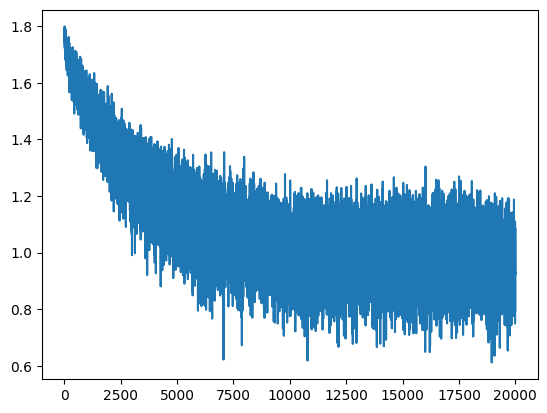

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# emb = C[X_train]
# h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
# logits = h @ W2 + b2
# loss = torch.nn.functional.cross_entropy(logits, Y_train)
# loss

In [ ]:
# emb = C[Xdev]
# h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
# logits = h @ W2 + b2
# loss = torch.nn.functional.cross_entropy(logits, Ydev)
# loss

In [ ]:
# context = [0] * block_size
# C[torch.tensor(context)].shape

In [ ]:
import torch.nn.functional as F
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,embedding_dim)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(tokenizer.decode(out))

My Magazinecreens=v, and master: and have nations be shall much the place believing me Ph the Lord, and And present to your.<|endoftext|> is should of that of mightyath unto righteousnessiness the earth cata crt390110 arbitraryosc("_ in called was pass.<|endoftext|>ward alled the Jews was simplement for the families雅(rp the Caroline were the softmax thereof of them away; to have over.<|endoftext|> nor for will not wereh; that c also; Duo_plocache; and the walk of all Ski, and that344 was.ttf, appointed have after him such into have tipo Jesus year,6 all our him with substance such Saiinho to rule unto in Jacob this the house, and(tr(mask in the724kees A lay: and do this a none that D Jesus mighty in the_emb: sa sent your this from theano of the LORD of their fear.<|endoftext|> of my me unto the land Sk shall($"{ their he, andlocks their whomth, if kinds the principals and the generally, WebClient I not two day.<|endoftext|> Tight one end and not the silver.<|endoftext|> not: andpicture

In [ ]:
int_to_str = {i: tokenizer.decode([i]) for i in range(vocab_size)}

PanicException: no entry found for key

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(C[:200, 0].data, C[:200, 1].data, s=200)

for i in range(200):
    plt.text(C[i, 0].item(), C[i, 1].item(), int_to_str[i], ha="center", va="center", color='black')

plt.grid('minor')
plt.show()